# Introduction

This notebook presents LSTM model training and prediction using ASRS and NTSB. 

### Ref

`Resample`: https://www.kaggle.com/code/rafjaa/resampling-strategies-for-imbalanced-datasets

https://github.com/danibrear/sklearn-cookbook/blob/master/Chapter%204/4.1.1%20Label%20Propagation%20with%20Semi-Supervised%20Learning.ipynb

# Import Library

In [169]:
%run notebook_functions.ipynb
%run notebook_proprocessing.ipynb

# Functions

In [166]:
def re_arrange_data(df):

    textPreprocessor = TextPreprocessor()
     # Step 1: Combine 'narrative_01' and 'narrative_02' into a single 'narrative' column
    df = textPreprocessor.combined_narrative(df)
    
     # Step 2: Combine 'narrative_01' and 'narrative_02' into a single 'narrative' column
    df = textPreprocessor.counting_narrative(df)

     # Step 3: clean narrative
    df = textPreprocessor.clean_narrative(df)

    # Step 4: Clean factor_column_name
    df = textPreprocessor.clean_feature(df, factor_column_name)

    # Step 5: Drop column narrative 01 and 02
    df = textPreprocessor.drop_narratives(df)

    # Step 6: Show summary
    textPreprocessor.show_summary(df)

    return df

def count_percentage(df, label_col):
    # Count unique values and their percentages
    value_counts = df[label_col].value_counts()  # counts
    percentages = df[label_col].value_counts(normalize=True) * 100  # percentages

    # Combine counts and percentages into a DataFrame
    result = pd.DataFrame({
        'Counts': value_counts,
        'Percentages': percentages
    })

    print(result)

def print_text(index, df, label):
    example = df[df.index == index][['narrative', label]].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])
    # print_plot(10, data, 'primary_problem')
    # print_plot(100, data, 'primary_problem')
    # print_plot(5, data, 'primary_problem')

import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Plot distribution of word counts using KDE

def show_narrative_distribution(data):
    plt.figure(figsize=(14, 6))

    word_count = data['narrative_word_count']

    plt.subplot(1, 2, 1)  # Create a subplot for word counts
    sns.histplot(word_count,  bins=50, color='blue', kde=True)
    plt.xlabel('Number of Words')
    plt.ylabel('Number of sample')
    plt.title('Distribution of Word Counts (KDE)')


    # Overlay mean (mu) and standard deviation (sigma) on the plot
    mean = word_count.mean()
    std = word_count.std()
    # Display mean and standard deviation on the plot
    plt.text(0.7, 0.9, r'$\mu={:.2f}$'.format(mean), transform=plt.gca().transAxes, fontsize=12)
    plt.text(0.7, 0.85, r'$\sigma={:.2f}$'.format(std), transform=plt.gca().transAxes, fontsize=12)


    # Step 3: Plot distribution of sentence counts using KDE
    sentence_count = data['narrative_sentence_count']

    plt.subplot(1, 2, 2)  # Create a subplot for sentence counts
    sns.histplot(sentence_count,  bins=30, color='green', kde=True)
    plt.xlabel('Number of Sentences')
    plt.ylabel('Number of sample')
    plt.title('Distribution of Sentence Counts (KDE)')

    # Overlay mean (mu) and standard deviation (sigma) on the plot
    mean = sentence_count.mean()
    std = sentence_count.std()
    # Display mean and standard deviation on the plot
    plt.text(0.7, 0.9, r'$\mu={:.2f}$'.format(mean), transform=plt.gca().transAxes, fontsize=12)
    plt.text(0.7, 0.85, r'$\sigma={:.2f}$'.format(std), transform=plt.gca().transAxes, fontsize=12)

    # Display the plots
    plt.tight_layout()
    plt.show()

# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

import re
import nltk
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    #    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# This should be the same as the 'num_words' in the tokenizer
MAX_NB_WORDS = 7500
# This is fixed.
EMBEDDING_DIM = 100

## Define X
def get_LSTM_X(df, max_length=300):

    # The maximum number of words to be used. (most frequent)
    
    texts = df['narrative'].values

    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

    tokenizer.fit_on_texts(texts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    sequences = tokenizer.texts_to_sequences(texts)

    X = pad_sequences(sequences, maxlen=max_length)

    print('Shape of data tensor:', X.shape)
    return X

## Define Y

def get_LSTM_Y(df):
    lstm_labels = df['HFACS_Category_Value_Predict'].values
    lstm_label_encoder = LabelEncoder()
    Y = lstm_label_encoder.fit_transform(lstm_labels)
    print('Shape of label tensor:', Y.shape)
    return lstm_label_encoder, Y

def get_X_Y_train_test(df):
    ## Text clean
    clean_df = df.reset_index(drop=True)
    clean_df['narrative'] = clean_df['narrative'].apply(clean_text)
    clean_df['narrative'] = clean_df['narrative'].str.replace('\d+', '')

    ## Tokenize
    # # Defining pre-processing parameters
    # max_len = 10000 
    # trunc_type = 'post'
    # padding_type = 'post'
    # oov_tok = '<OOV>' # out of vocabulary token
    # vocab_size = 500

    X = get_LSTM_X(clean_df, max_length=250)

    lstm_label_encoder, Y = get_LSTM_Y(clean_df)
    df['HFACS_Category_Value_Predict_Encode'] = Y

    ## Define Train & Test
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
    print(X_train.shape,Y_train.shape)
    print(X_test.shape,Y_test.shape)
    return lstm_label_encoder, X, Y, X_train, X_test, Y_train, Y_test

from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def train_LSTM(X, Y, X_train, Y_train, lstm_label_encoder, epochs=5, batch_size=128):
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.3))
    # model.add(LSTM(units=64, dropout=0.3, recurrent_dropout=0.3))
    model.add(LSTM(units=64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
    model.add(LSTM(units=64, dropout=0.3, recurrent_dropout=0.3))
    # model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))  # Add a second LSTM layer
    
    model.add(Dense(len(lstm_label_encoder.classes_), activation='softmax', kernel_regularizer=l2(0.001)))

    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001),  metrics=['accuracy'])

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', 
        patience=2, 
        min_delta=0.001)
    
    # Train the model
    history = model.fit(X_train, Y_train, 
        epochs=10, 
        batch_size=32, 
        validation_split=0.1, 
        callbacks=[early_stopping])

    # history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

    return history, model

def model_summary(history, model):
    model.summary()

    accr = model.evaluate(X_test,Y_test)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

    # Loss Chart
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    # Accuracy chart
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()
    

#  Confusion Matrix
def show_confusion_matrix(best_model, X_test, y_test, lstm_label_encoder):
    # Predict the classes for the test set
    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lstm_label_encoder.classes_, yticklabels=lstm_label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y_test, y_pred_classes))


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



<>:97: SyntaxWarning: invalid escape sequence '\['
<>:158: SyntaxWarning: invalid escape sequence '\d'
<>:97: SyntaxWarning: invalid escape sequence '\['
<>:158: SyntaxWarning: invalid escape sequence '\d'
/var/folders/__/wffwy8dx6l53rqlg01sth6th0000gn/T/ipykernel_25371/31495031.py:97: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
/var/folders/__/wffwy8dx6l53rqlg01sth6th0000gn/T/ipykernel_25371/31495031.py:158: SyntaxWarning: invalid escape sequence '\d'
  clean_df['narrative'] = clean_df['narrative'].str.replace('\d+', '')


# ASRS

## Get Data

In [167]:
# Steo 01: Get data
asrs_df = get_data('asrs')

In [170]:
asrs_df = re_arrange_data(asrs_df)

event_id                    0
finding_description         0
narrative                   0
narrative_length            0
narrative_word_count        0
narrative_sentence_count    0
dtype: int64


## Labeling Data

In [154]:
# 02. Labeling HFACS taxonomy

sample_df = asrs_df.sample(n=5000, random_state=42)
asrs_predicted_data = predict_LS(sample_df, 'asrs')

# model_data = labeled_data[labeled_data['HFACS_Category_Value_Predict'] != 'Unmapped'].copy()



Model and vectorizer loaded successfully


## Pre Processing

In [155]:
clean_df = asrs_predicted_data.reset_index(drop=True)

clean_df = preprocess_narrative(clean_df)

# clean_df['narrative'] = clean_df['narrative'].str.replace('\d+', '')
clean_df['narrative'] = clean_df['narrative'].apply(lambda x: ' '.join(x))
clean_df

,event_id,finding_description,narrative,narrative_length,narrative_word_count,narrative_sentence_count,HFACS_Category_Value_Predict
0,503700,Human Factors,flt attend rpted metal roll bang nois gnd zzz ...,739,131,10,Decision/Skill-based/Perceptual Errors
1,190837,Human Factors,acr x clred po rwi 27l phl acr hvi depart 27l ...,782,154,11,Decision/Skill-based/Perceptual Errors
2,529256,Aircraft:Waste Water Disposal System:Failed:Ai...,acft x arriv zzz approx xa30 leak first class ...,704,141,8,Technological Environment
3,1499687,Aircraft:Main Gear Tire:Failed:Aircraft Equipm...,upon takeoff first offic fli captain call v1 f...,1973,361,24,Technological Environment
4,542859,Aircraft:Engine:Failed:Aircraft Equipment Prob...,acr flt mco na approx 20 nm lndg vector vor dm...,1264,217,16,Technological Environment
...,...,...,...,...,...,...,...
4995,538069,Human Factors,aerial survey part 91 plt tri follow rapidli c...,1613,289,20,Decision/Skill-based/Perceptual Errors
4996,274357,Aircraft:Airspeed Indicator:Malfunctioning:Air...,737300 acft involv reject tkof ind arpt involv...,614,104,7,Technological Environment
4997,1538625,Environment - Non Weather Related:GPS & Other ...,autopilot use ifr certifi gp track direct pln ...,490,85,5,Technological Environment
4998,223300,Chart Or Publication,enrt seattl grand canyon navig tuck corridor e...,431,73,6,Organizational Climate/Organizational Process/...


In [156]:
clean_df = counting_narrative(clean_df)
clean_df

,event_id,finding_description,narrative,narrative_length,narrative_word_count,narrative_sentence_count,HFACS_Category_Value_Predict
0,503700,Human Factors,flt attend rpted metal roll bang nois gnd zzz ...,433,74,1,Decision/Skill-based/Perceptual Errors
1,190837,Human Factors,acr x clred po rwi 27l phl acr hvi depart 27l ...,432,83,1,Decision/Skill-based/Perceptual Errors
2,529256,Aircraft:Waste Water Disposal System:Failed:Ai...,acft x arriv zzz approx xa30 leak first class ...,446,82,1,Technological Environment
3,1499687,Aircraft:Main Gear Tire:Failed:Aircraft Equipm...,upon takeoff first offic fli captain call v1 f...,1166,194,1,Technological Environment
4,542859,Aircraft:Engine:Failed:Aircraft Equipment Prob...,acr flt mco na approx 20 nm lndg vector vor dm...,775,132,1,Technological Environment
...,...,...,...,...,...,...,...
4995,538069,Human Factors,aerial survey part 91 plt tri follow rapidli c...,1005,182,1,Decision/Skill-based/Perceptual Errors
4996,274357,Aircraft:Airspeed Indicator:Malfunctioning:Air...,737300 acft involv reject tkof ind arpt involv...,380,63,1,Technological Environment
4997,1538625,Environment - Non Weather Related:GPS & Other ...,autopilot use ifr certifi gp track direct pln ...,333,51,1,Technological Environment
4998,223300,Chart Or Publication,enrt seattl grand canyon navig tuck corridor e...,273,44,1,Organizational Climate/Organizational Process/...


                                                    Counts  Percentages
HFACS_Category_Value_Predict                                           
Decision/Skill-based/Perceptual Errors                2107        42.14
Technological Environment                             1879        37.58
Organizational Climate/Organizational Process/R...     412         8.24
Physical Environment                                   291         5.82
Crew Resource Management/Personal Readiness            204         4.08
Adverse Mental State/Adverse Physiological Stat...     107         2.14


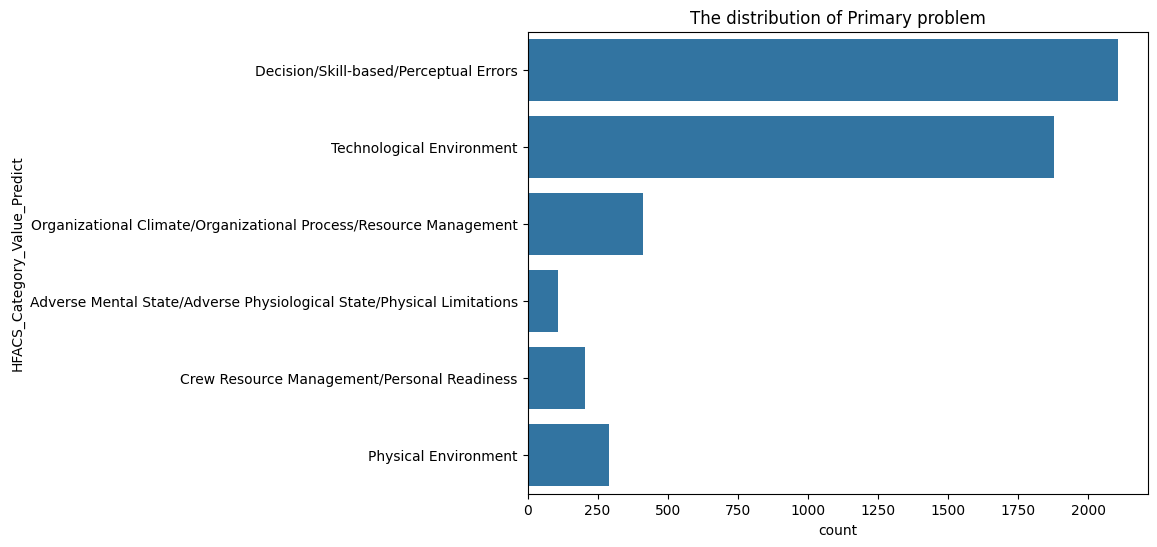

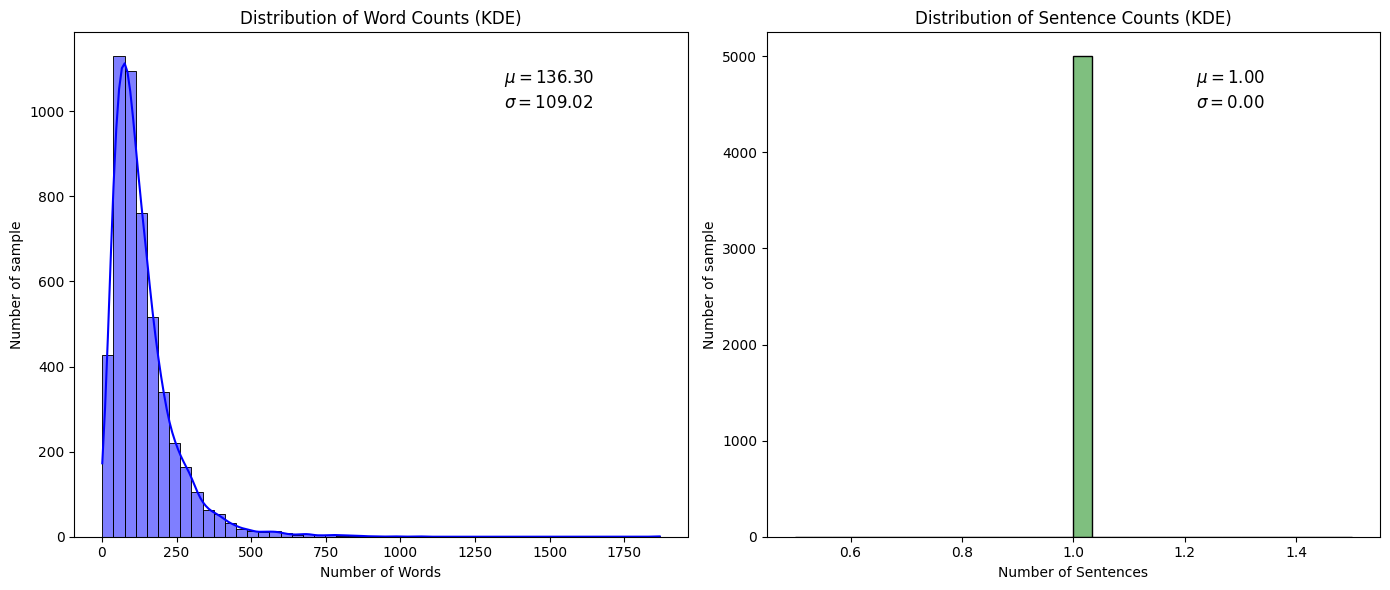

In [157]:
## Visualize
show_label(clean_df, 'HFACS_Category_Value_Predict')
count_percentage(clean_df, 'HFACS_Category_Value_Predict')

show_narrative_distribution(clean_df)

## Handling imbalance data
Approach to deal with the imbalanced dataset problem:

Choose proper evaluation metric

Resampling (oversampling and undersampling)

Synthetic Minority Oversampling Technique (SMOTE)

BalancedBaggingClassifier

Threshold moving

In [32]:
## Text clean
# clean_df = asrs_predicted_data.reset_index(drop=True)
# clean_df['narrative'] = clean_df['narrative'].apply(clean_text)
# clean_df['narrative']

0      flt attendant rpted metallic rolling banging n...
1      acr clred pos rwy 27l phl acr y hvy departed 2...
2      acft arrived zzz appro a30 leak first class la...
3      upon takeoff first officer flying captain call...
4      acr flt mco nas appro 20 nm lndg vectored vor ...
                             ...                        
995    cleared visual approach planning flaps 45 land...
996    enrte ags received normal dscnt ing restr 1100...
997    initially clred tkof clb 2000 ft delayed tkof ...
998    first inform flying appro 500 hrs 1984 never p...
999    working high sector fl240fl330 ww24 checks fre...
Name: narrative, Length: 1000, dtype: object

In [158]:
## Text clean
# clean_df = asrs_predicted_data.reset_index(drop=True)
# clean_df['narrative'] = clean_df['narrative'].apply(clean_text)
# clean_df['narrative'] = clean_df['narrative'].str.replace('\d+', '')

## Tokenize
# # Defining pre-processing parameters
# max_len = 10000 
# trunc_type = 'post'
# padding_type = 'post'
# oov_tok = '<OOV>' # out of vocabulary token
# vocab_size = 500

# This is fixed.
EMBEDDING_DIM = 100

X = get_LSTM_X(clean_df, max_length=250)

lstm_label_encoder, Y = get_LSTM_Y(clean_df)

## Define Train & Test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Found 19247 unique tokens.
Shape of data tensor: (5000, 250)
Shape of label tensor: (5000,)
(4500, 250) (4500,)
(500, 250) (500,)


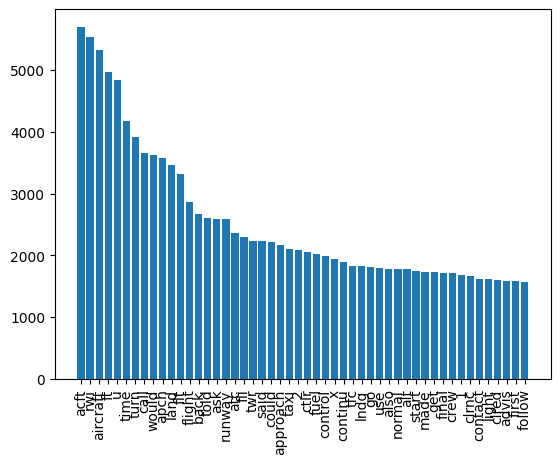

Total unique words: 19247


In [159]:
from collections import Counter
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# def remove_stopwords(text):
#     return ' '.join([word for word in text.split() if word not in stop_words])

def remove_stopwords(text):
    return [word for word in text.split() if word not in stop_words]

# def remove_stopwords(text):
#     # Split text into words, remove stopwords, then return the processed text as a string
#     # output = [word for word in text.split() if word.lower() not in stop_words]
#     return [word for word in text if word not in stop_words]

# Apply the function to your DataFrame
# clean_df['narrative_cleaned'] = clean_df['narrative'].apply(lambda x:remove_stopwords(x))
# https://docs.python.org/3/library/collections.html#collections.Counter
# Assuming you have a list of all words in your dataset
all_words = [word for text in clean_df['narrative'].values for word in text.split()]
word_counts = Counter(all_words)

# Plot top 50 most frequent words
common_words = word_counts.most_common(50)
labels, values = zip(*common_words)
plt.bar(labels, values)
plt.xticks(rotation=90)
plt.show()

# Print the number of unique words in your dataset
print(f"Total unique words: {len(word_counts)}")

## Model Building

/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_modules/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 161ms/step - accuracy: 0.3755 - loss: 1.7261 - val_accuracy: 0.4156 - val_loss: 1.3166
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.4189 - loss: 1.3363 - val_accuracy: 0.4222 - val_loss: 1.3074
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - accuracy: 0.4222 - loss: 1.3228 - val_accuracy: 0.4156 - val_loss: 1.2768
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 23s 178ms/step - accuracy: 0.4478 - loss: 1.2532 - val_accuracy: 0.5222 - val_loss: 1.2134
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step - accuracy: 0.4942 - loss: 1.1855 - val_accuracy: 0.5422 - val_loss: 1.1887
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 195ms/step - accuracy: 0.5388 - loss: 1.1331 - val_accuracy: 0.5711 - val_loss: 1.1541
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - accuracy: 0.5721 - loss: 1.0892 - val_accuracy: 0.5756 - val_loss: 1.1392
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 195ms/step - accuracy: 0.6161 - loss: 1

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 250, 100)       │       750,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_9             │ (None, 250, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 250, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,476,964 (9.45 MB)

 Trainable params: 825,654 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,651,310 (6.30 MB)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6068 - loss: 1.1413
Test set
  Loss: 1.120
  Accuracy: 0.626


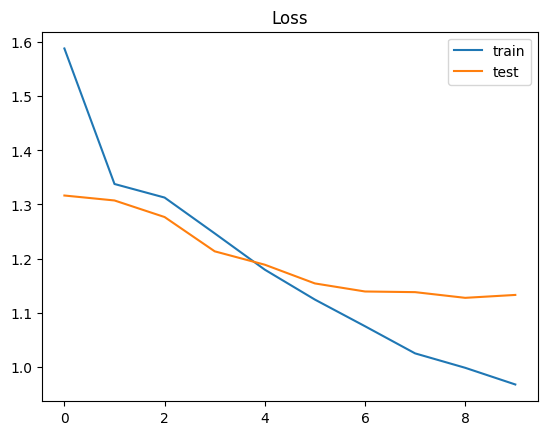

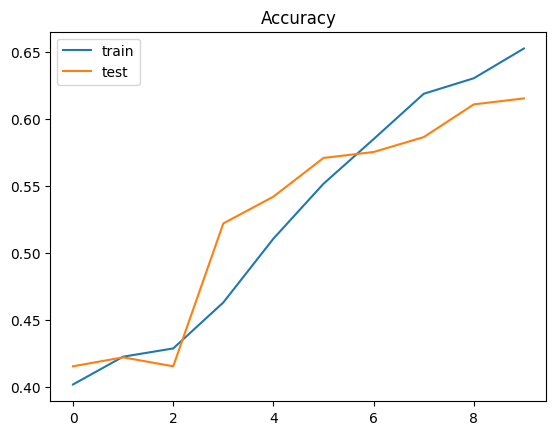

In [160]:
history, model = train_LSTM(X, Y, X_train, Y_train, lstm_label_encoder, 10)

model_summary(history, model)



16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


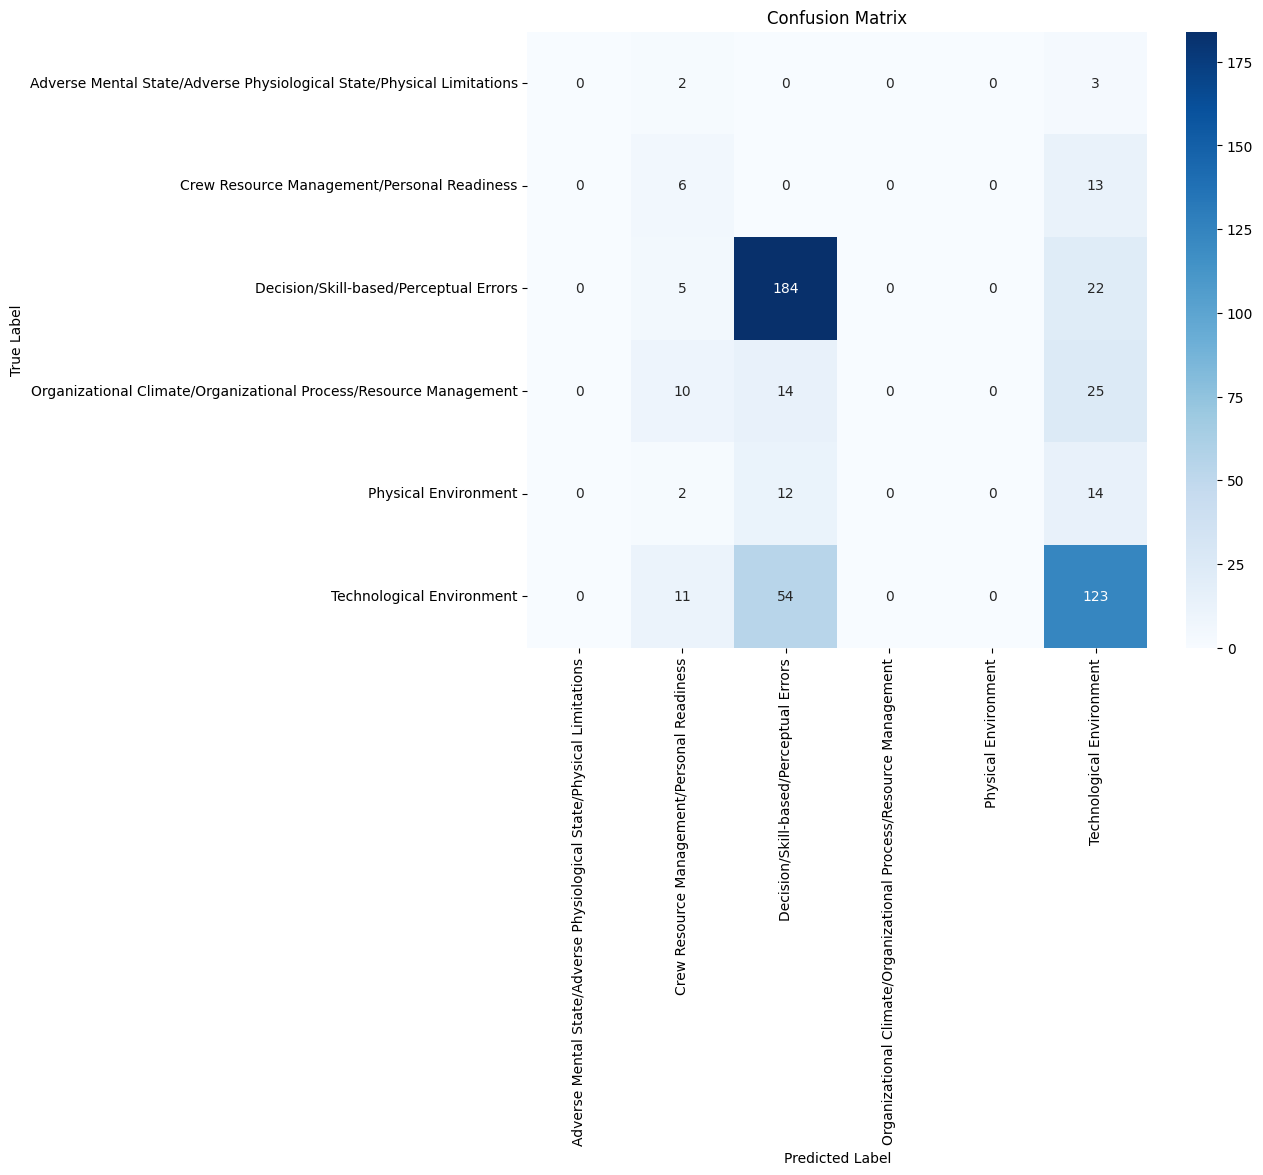

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.17      0.32      0.22        19
           2       0.70      0.87      0.77       211
           3       0.00      0.00      0.00        49
           4       0.00      0.00      0.00        28
           5       0.61      0.65      0.63       188

    accuracy                           0.63       500
   macro avg       0.25      0.31      0.27       500
weighted avg       0.53      0.63      0.57       500



/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_modules/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_modules/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_module

In [163]:
# def show_confusion_matrix(best_model, X_test, y_test, lstm_label_encoder):
#     # Predict the classes for the test set (predict returns probabilities)
#     y_pred = best_model.predict(X_test)
    

#     # print(y_pred)

#     # Convert probabilities to class indices
#     y_pred_classes = np.argmax(y_pred, axis=1)

#     print(y_pred_classes)

#     # Ensure that y_test is integer-encoded (check this before proceeding)

#     print(y_test)

#     # if not isinstance(y_test[0], int):
#     #     raise ValueError("y_test should be integer-encoded labels.")

#     # Generate the confusion matrix
#     conf_matrix = confusion_matrix(y_test, y_pred_classes)

#     # Plot the confusion matrix
#     plt.figure(figsize=(10,8))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
#                 xticklabels=lstm_label_encoder.classes_, 
#                 yticklabels=lstm_label_encoder.classes_)
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title('Confusion Matrix')
#     plt.show()

show_confusion_matrix(model, X_test, Y_test, lstm_label_encoder)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Accuracy: 0.6260
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.17      0.32      0.22        19
           2       0.70      0.87      0.77       211
           3       0.00      0.00      0.00        49
           4       0.00      0.00      0.00        28
           5       0.61      0.65      0.63       188

    accuracy                           0.63       500
   macro avg       0.25      0.31      0.27       500
weighted avg       0.53      0.63      0.57       500

ROC AUC Score: 0.7639


/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_modules/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_modules/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_module

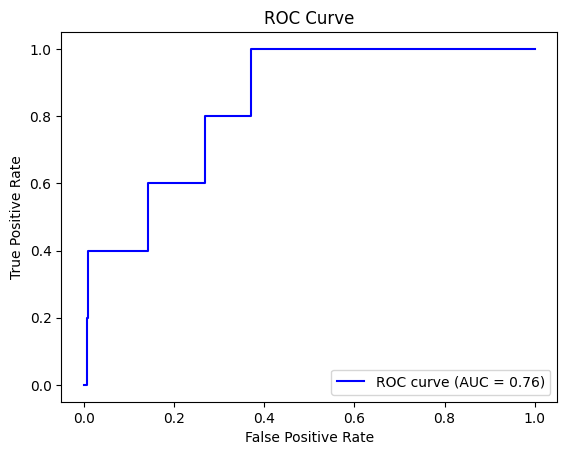

In [164]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Predict the probabilities for the test set
y_pred = model.predict(X_test)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Accuracy
accuracy = accuracy_score(Y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Classification report for precision, recall, F1-score
print(classification_report(Y_test, y_pred_classes))

# Binarize the output for AUC/ROC computation (for multiclass case)
Y_test_binarized = label_binarize(Y_test, classes=np.unique(Y_test))

# Compute ROC AUC score (one-vs-rest)
roc_auc = roc_auc_score(Y_test_binarized, y_pred, multi_class='ovr')
print(f'ROC AUC Score: {roc_auc:.4f}')

# Plot ROC Curve for one of the classes
fpr, tpr, thresholds = roc_curve(Y_test_binarized[:, 0], y_pred[:, 0])  # For class 0

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# NTSB

In [90]:
ntsb_df = get_data('ntsb')
ntsb_df = clean_data(ntsb_df)

event_id                    0
finding_description         0
narrative                   0
narrative_length            0
narrative_word_count        0
narrative_sentence_count    0
dtype: int64


/var/folders/__/wffwy8dx6l53rqlg01sth6th0000gn/T/ipykernel_29271/1300457799.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=[factor_column_name], inplace=True)


Model and vectorizer loaded successfully
                                  Counts  Percentages
HFACS_Category_Value_Predict                         
Technological Environment           1803        36.06
Skill-based Errors                  1133        22.66
Physical Environment                1005        20.10
Decision Errors                      592        11.84
Adverse Mental State                 166         3.32
Personal Readiness                   100         2.00
Organizational Process                77         1.54
Adverse Physiological State           57         1.14
Perceptual Errors                     34         0.68
Resource Management                   17         0.34
Organizational Climate                 6         0.12
Physical Limitations                   5         0.10
Routine / Exceptional Violations       5         0.10


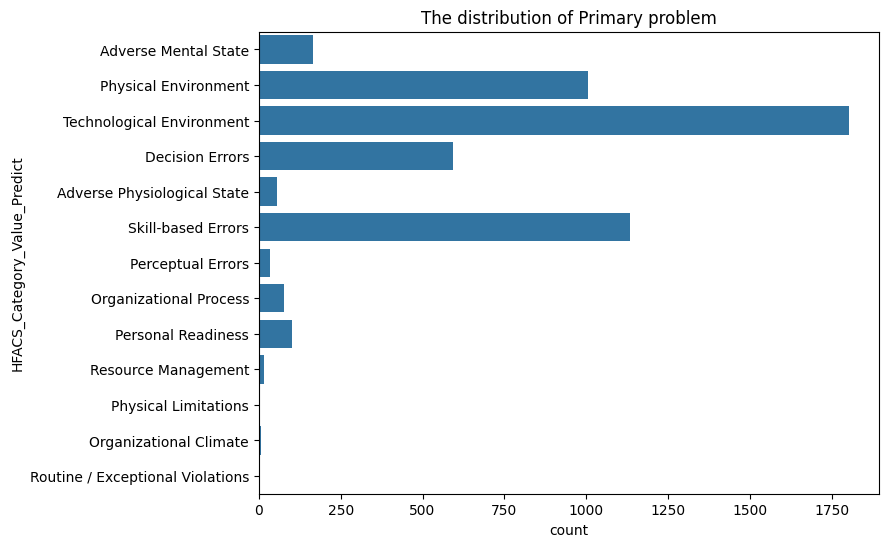

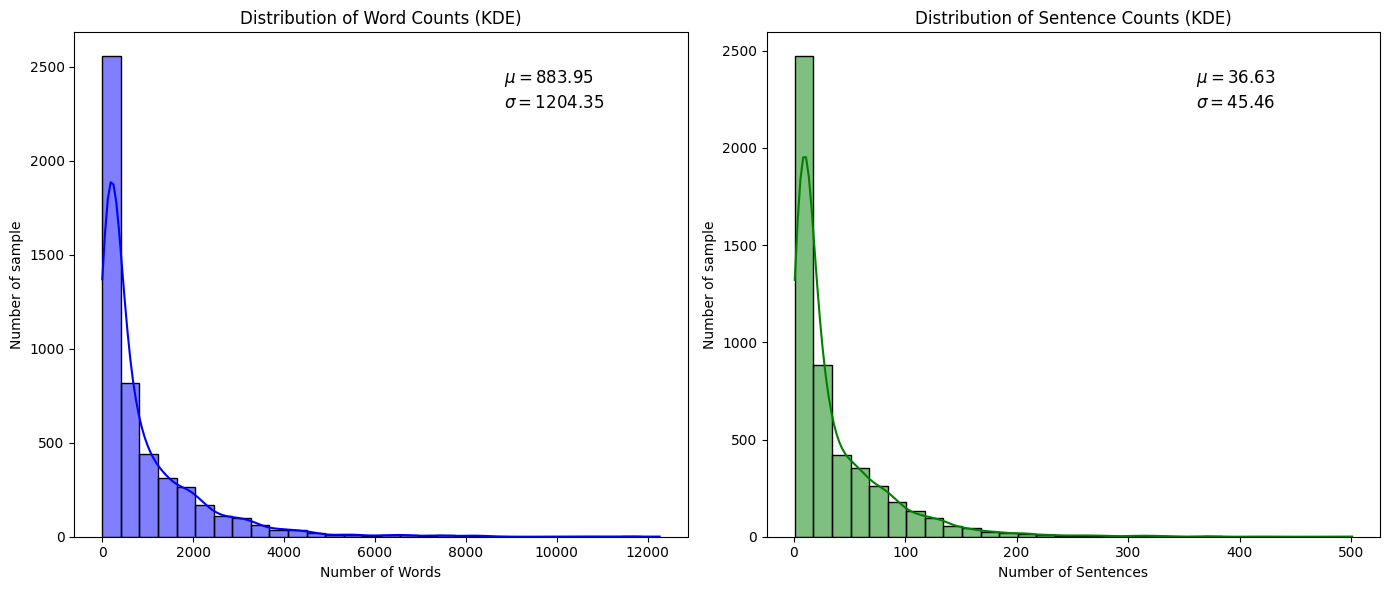

In [97]:
# 02. Labeling HFACS taxonomy
sample_df = ntsb_df.sample(n=5000, random_state=42)
ntsb_predicted_data = predict_LS(sample_df, 'ntsb')

# model_data = labeled_data[labeled_data['HFACS_Category_Value_Predict'] != 'Unmapped'].copy()

## Visualize
show_label(ntsb_predicted_data, 'HFACS_Category_Value_Predict')
count_percentage(ntsb_predicted_data, 'HFACS_Category_Value_Predict')

show_narrative_distribution(ntsb_predicted_data)

In [98]:
## Text clean
clean_df = ntsb_predicted_data.reset_index(drop=True)
clean_df['narrative'] = clean_df['narrative'].apply(clean_text)
clean_df['narrative'] = clean_df['narrative'].str.replace('\d+', '')

## Tokenize
# # Defining pre-processing parameters
# max_len = 10000 
# trunc_type = 'post'
# padding_type = 'post'
# oov_tok = '<OOV>' # out of vocabulary token
# vocab_size = 500

# This is fixed.
EMBEDDING_DIM = 100

X = get_LSTM_X(clean_df, max_length=800)

lstm_label_encoder, Y = get_LSTM_Y(clean_df)

## Define Train & Test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
/var/folders/__/wffwy8dx6l53rqlg01sth6th0000gn/T/ipykernel_29271/3790182687.py:4: SyntaxWarning: invalid escape sequence '\d'
  clean_df['narrative'] = clean_df['narrative'].str.replace('\d+', '')


Found 70087 unique tokens.
Shape of data tensor: (5000, 800)
Shape of label tensor: (5000,)
(4500, 800) (4500,)
(500, 800) (500,)


/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_modules/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2845 - loss: 2.2758 - val_accuracy: 0.3622 - val_loss: 1.7419
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3579 - loss: 1.6612 - val_accuracy: 0.3622 - val_loss: 1.7297
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3677 - loss: 1.6613 - val_accuracy: 0.3622 - val_loss: 1.7227
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3544 - loss: 1.6490 - val_accuracy: 0.3600 - val_loss: 1.7128
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.3754 - loss: 1.5969 - val_accuracy: 0.3511 - val_loss: 1.7349
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.4646 - loss: 1.4719 - val_accuracy: 0.3311 - val_loss: 1.7670
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5630 - loss: 1.2859 - val_accuracy: 0.3267 - val_loss: 1.8827


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 800, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_16            │ (None, 800, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 13)             │         1,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,245,141 (58.16 MB)

 Trainable params: 5,081,713 (19.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,163,428 (38.77 MB)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.3351 - loss: 1.7925
Test set
  Loss: 1.780
  Accuracy: 0.338


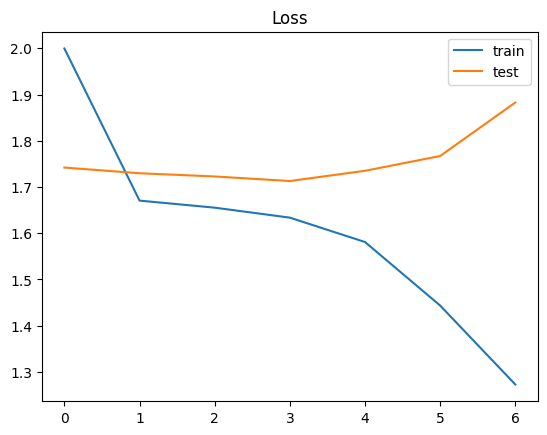

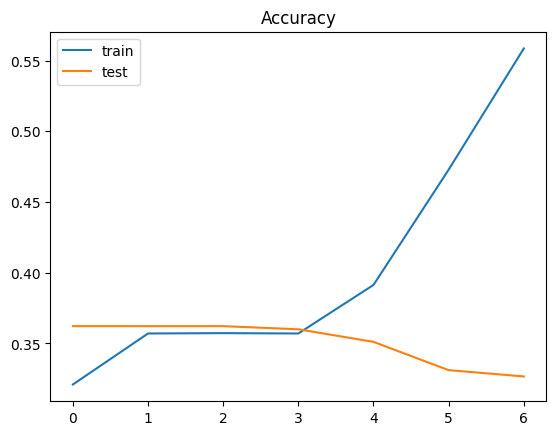

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


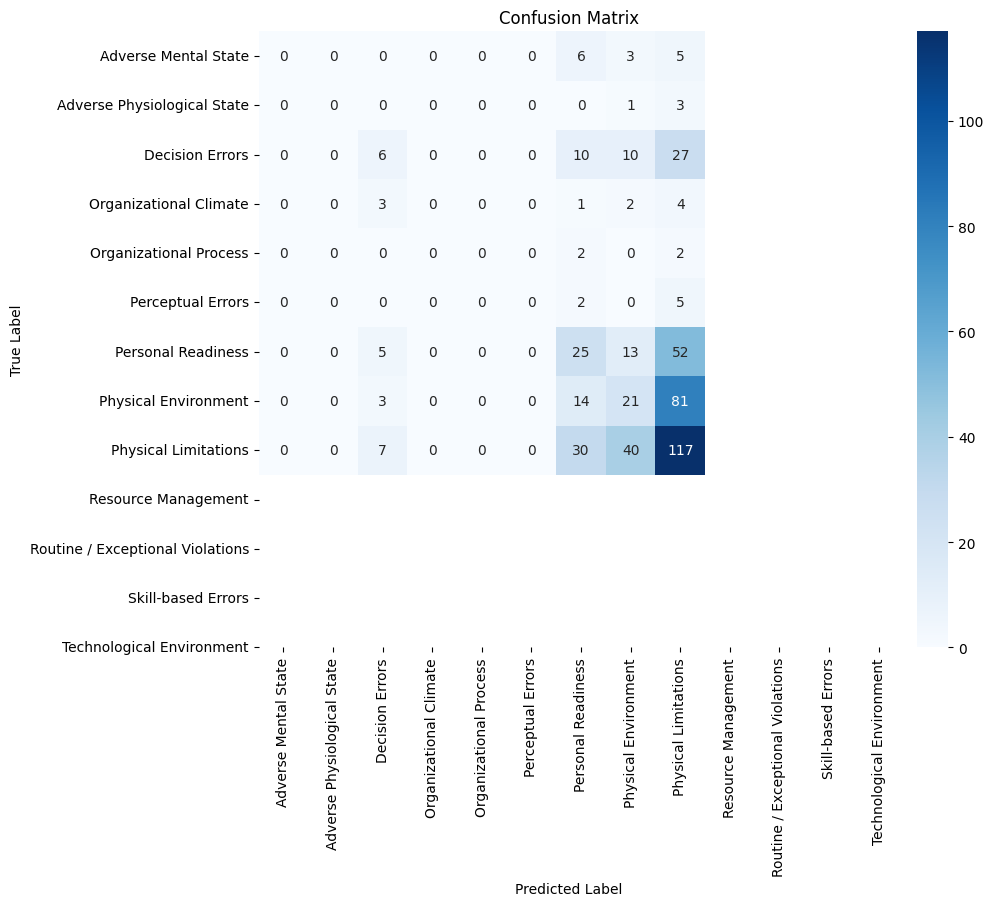

In [99]:
history, model = train_LSTM(X, Y, X_train, Y_train, lstm_label_encoder, 10)

model_summary(history, model)

show_confusion_matrix(model, X_test, Y_test, lstm_label_encoder)


# ASRS & NTSB (Combine)

Model and vectorizer loaded successfully
                                  Counts  Percentages
HFACS_Category_Value_Predict                         
Technological Environment           3701        37.01
Skill-based Errors                  3258        32.58
Physical Environment                1244        12.44
Decision Errors                      583         5.83
Adverse Mental State                 348         3.48
Organizational Process               291         2.91
Crew Resource Management             194         1.94
Organizational Climate               149         1.49
Personal Readiness                    96         0.96
Adverse Physiological State           57         0.57
Perceptual Errors                     50         0.50
Resource Management                   20         0.20
Routine / Exceptional Violations       8         0.08
Physical Limitations                   1         0.01


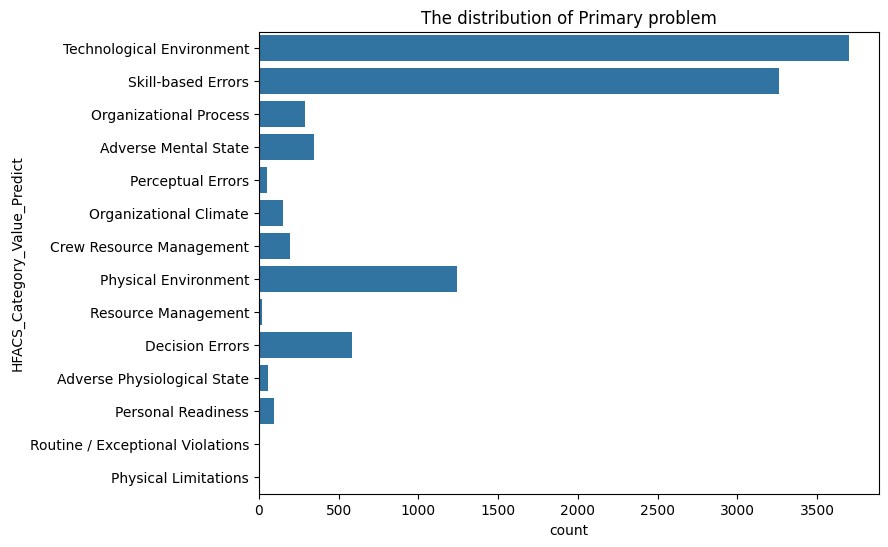

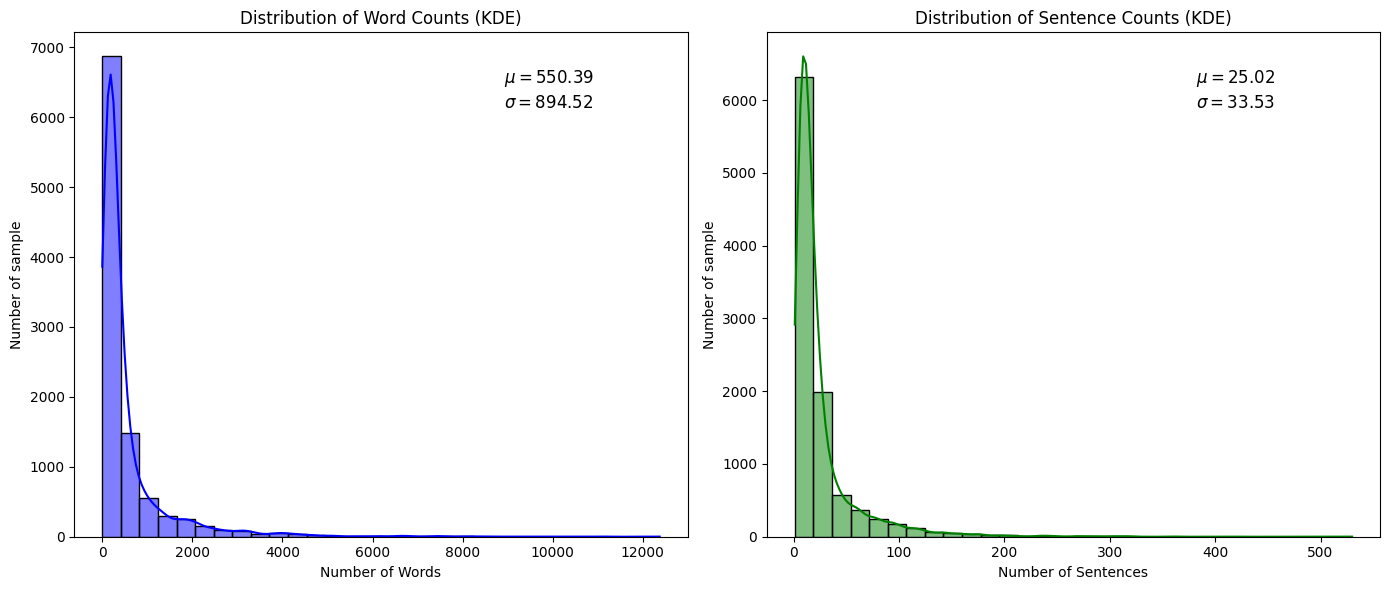

In [102]:
# 01. Manual Labeling with specific sample
asrs_sample_df = asrs_df.sample(n=5000, random_state=43)
ntsb_sample_df = ntsb_df.sample(n=5000, random_state=43)

asrs_ntsb_sample_data = pd.concat([asrs_sample_df, ntsb_sample_df], axis=0).reset_index(drop=True)

asrs_ntsb_labeled_data = predict_LS(asrs_ntsb_sample_data, 'asrs_ntsb')

## Visualize
show_label(asrs_ntsb_labeled_data, 'HFACS_Category_Value_Predict')
count_percentage(asrs_ntsb_labeled_data, 'HFACS_Category_Value_Predict')

show_narrative_distribution(asrs_ntsb_labeled_data)

In [104]:
asrs_ntsb_labeled_data

,event_id,finding_description,narrative,narrative_length,narrative_word_count,narrative_sentence_count,HFACS_Category_Value_Predict
0,1417449,Procedure:Emergency Brake System:Improperly Op...,During preflight; maintenance responded to the...,4188,736,35,Technological Environment
1,530978,ATC Equipment / Nav Facility / Buildings,WE DEPARTED EUG ARPT ON THE EUG 5 DEP; AS ASSI...,1924,395,23,Technological Environment
2,80710,Human Factors,I INADVERTENTLY CLRD MLG X TO FILED ALT OF FL3...,1396,279,16,Skill-based Errors
3,259823,Human Factors,STOPPED AT MEDFORD; OR; TO REFUEL ACFT. STARTE...,865,160,13,Skill-based Errors
4,826011,Aircraft:Flap/Slat Control System:Failed:Aircr...,After selecting flaps 2 degrees on the approac...,785,137,8,Technological Environment
...,...,...,...,...,...,...,...
9995,20150824X93135,Aircraft-Aircraft oper/perf/capability-Perform...,"HISTORY OF FLIGHTOn August 21, 2015, about 142...",9044,1404,54,Technological Environment
9996,20140523X44003,Environmental issues-Physical environment-Obje...,"On May 23, 2014, about 1030 Pacific daylight t...",9294,1463,61,Physical Environment
9997,20190502X63800,Environmental issues-Physical environment-Obje...,"The helicopter pilot reported that, after an a...",1130,172,7,Physical Environment
9998,20100726X85651,Personnel issues-Task performance-Use of equip...,"In a written statement, the pilot reported tha...",996,157,8,Skill-based Errors


Found 77972 unique tokens.
Shape of data tensor: (10000, 500)
Shape of label tensor: (10000,)
(9000, 500) (9000,)
(1000, 500) (1000,)


/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_modules/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 849ms/step - accuracy: 0.3065 - loss: 2.1306 - val_accuracy: 0.3700 - val_loss: 1.5324
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 844ms/step - accuracy: 0.4056 - loss: 1.6284 - val_accuracy: 0.4967 - val_loss: 1.4710
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 56s 876ms/step - accuracy: 0.5048 - loss: 1.4959 - val_accuracy: 0.4644 - val_loss: 1.4151
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 56s 871ms/step - accuracy: 0.5742 - loss: 1.2734 - val_accuracy: 0.4522 - val_loss: 1.4196
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 851ms/step - accuracy: 0.6253 - loss: 1.0940 - val_accuracy: 0.4756 - val_loss: 1.5207
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 860ms/step - accuracy: 0.6823 - loss: 0.9259 - val_accuracy: 0.4778 - val_loss: 1.5745


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 500, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_17            │ (None, 500, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 14)             │         1,414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,245,444 (58.16 MB)

 Trainable params: 5,081,814 (19.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,163,630 (38.77 MB)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.4440 - loss: 1.6701
Test set
  Loss: 1.659
  Accuracy: 0.446


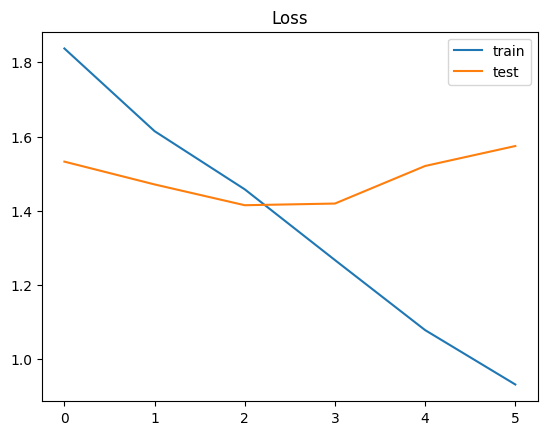

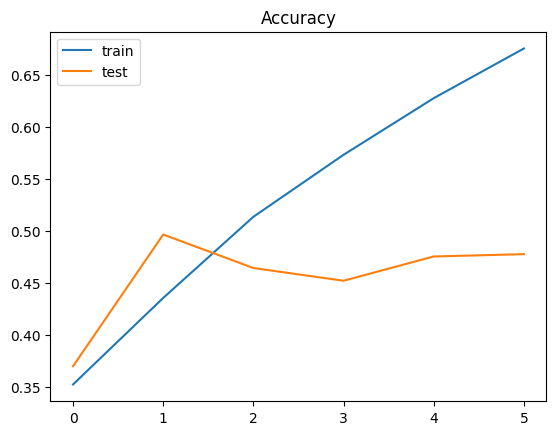

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step


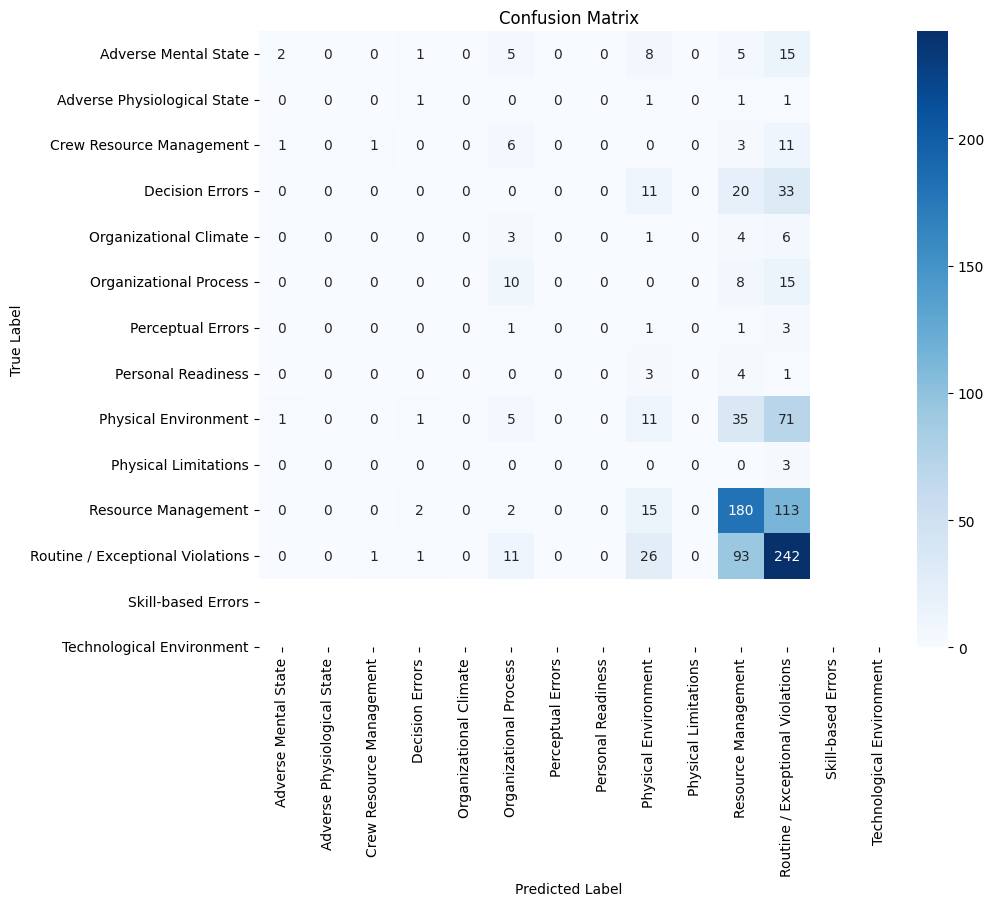

In [113]:
lstm_label_encoder, X, Y, X_train, X_test, Y_train, Y_test = get_X_Y_train_test(asrs_ntsb_labeled_data)


history, model = train_LSTM(X, Y, X_train, Y_train, lstm_label_encoder, 10)

model_summary(history, model)

show_confusion_matrix(model, X_test, Y_test, lstm_label_encoder)
